In [1]:
import torch
import wandb
import os

import matplotlib.pyplot as plt

from inference.bayesian.models import TorchModel
# from inference.bayesian.utils import plot_forecast
from inference.inference import inference
from ESN.utils import run_esn

import pyro

In [2]:
config = {
            "dataset": "acea",
            "model_widths": [50, 20, 1],
            "activation": "tanh",
            "distributions": ["gauss", "unif", "gauss"],
            "parameters": [[0,1],[0,10]],
            "dim_reduction": False,
            "inference": "q_regr",
            "lr": 0.03,
            "num_iterations": 120,
            "quantile": 0.95,
            "plot": False
            }

os.environ["WANDB_MODE"]="offline"
wandb.init(project="bayes_rc", config=config)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]='0'

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
Ytr, train_embedding, val_embedding, Yte, test_embedding = run_esn(config.dataset, device, dim_reduction=config.dim_reduction)

Tr: 4882, Val: 1047, Te: 1047


# Quantile Regression

In [11]:
QR_torch_model = TorchModel(config.model_widths, config.activation).to(device)

In [6]:
predictive, diagnostics = inference(config, QR_torch_model, None, X_train=train_embedding, Y_train=Ytr, X_test=test_embedding, Y_test=Yte, num_samples=None)

[iteration 0001] loss: 1.2753
[iteration 0021] loss: 6.7512
[iteration 0041] loss: 6.7295
[iteration 0061] loss: 6.7510
[iteration 0081] loss: 6.7588
[iteration 0101] loss: 6.7395


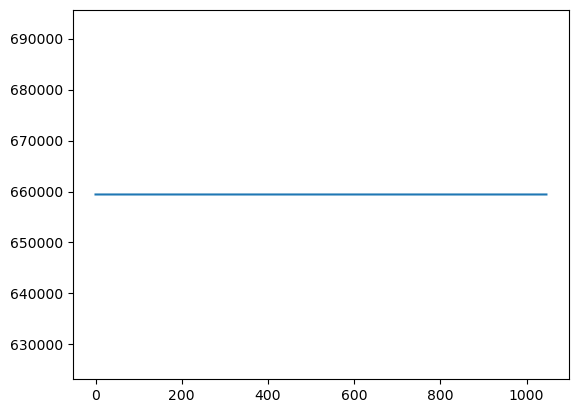

In [10]:
import matplotlib.pyplot as plt

plt.plot(predictive.detach().cpu().numpy())

testing

https://github.com/ceshine/quantile-regression-tensorflow/blob/master/notebooks/03-sklearn-example-pytorch.ipynb

In [4]:
import numpy as np

In [26]:
class TestModel(torch.nn.Module):
    """
    Deterministic model

    :param list widths: List of layers' widths.
    :param string activation: String specifying the activation function to use.
    """
    def __init__(self, widths):
        super().__init__()
        self.layers = torch.nn.ModuleList(
            [
                torch.nn.Linear(widths[0], widths[1]),
                torch.nn.Tanh(),
                torch.nn.Linear(widths[1], widths[2]),
                # torch.nn.Tanh(),
                # torch.nn.Linear(widths[2], widths[3]),
            ]
        )

    def forward(self, x):
        for f in self.layers:
            x = f(x)
        return x

In [27]:
model = TestModel([50, 20, 1]).to(device)

In [7]:
def qloss(preds, target, quantiles):
    losses = []
    for i, q in enumerate(quantiles):
        errors = target - preds[:, i]
        losses.append(torch.max((q-1) * errors, q * errors).unsqueeze(1))
    loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
    return loss

In [29]:
epochs = 200
batch_size = 1

model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-5)

x = train_embedding
y = Ytr

for e in range(epochs):
    # shuffle_idx = np.arange(x.shape[0])
    # np.random.shuffle(shuffle_idx)
    # x = x[shuffle_idx]
    # y = y[shuffle_idx]
    epoch_losses = []
    for idx in range(0, x.shape[0], batch_size):
        optimizer.zero_grad()
        batch_x = x[idx : min(idx + batch_size, x.shape[0]),:].requires_grad_(False)
        batch_y = y[idx : min(idx + batch_size, y.shape[0])].requires_grad_(False)
        preds = model(batch_x)
        # loss = qloss(preds, batch_y, [0.5])
        loss = torch.nn.functional.mse_loss(preds, batch_y)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.cpu().detach().numpy())                                
    epoch_loss =  np.mean(epoch_losses)
    if (e+1) % 10 == 0:
        print("Epoch {}: {}".format(e+1, epoch_loss))

Epoch 10: 0.7568449378013611
Epoch 20: 1.1774537563323975
Epoch 30: 0.8201647996902466
Epoch 40: 0.8931370973587036
Epoch 50: 0.9793506860733032
Epoch 60: 0.8880887627601624
Epoch 70: 0.8830177187919617
Epoch 80: 0.7547990083694458
Epoch 90: 0.5782409906387329
Epoch 100: 0.5751908421516418
Epoch 110: 0.6250222325325012
Epoch 120: 0.6809111833572388
Epoch 130: 0.6993670463562012
Epoch 140: 0.5181021690368652
Epoch 150: 0.6644018888473511
Epoch 160: 0.6225602030754089
Epoch 170: 0.5727689862251282
Epoch 180: 0.5317583680152893
Epoch 190: 0.787032961845398
Epoch 200: 0.5725263953208923


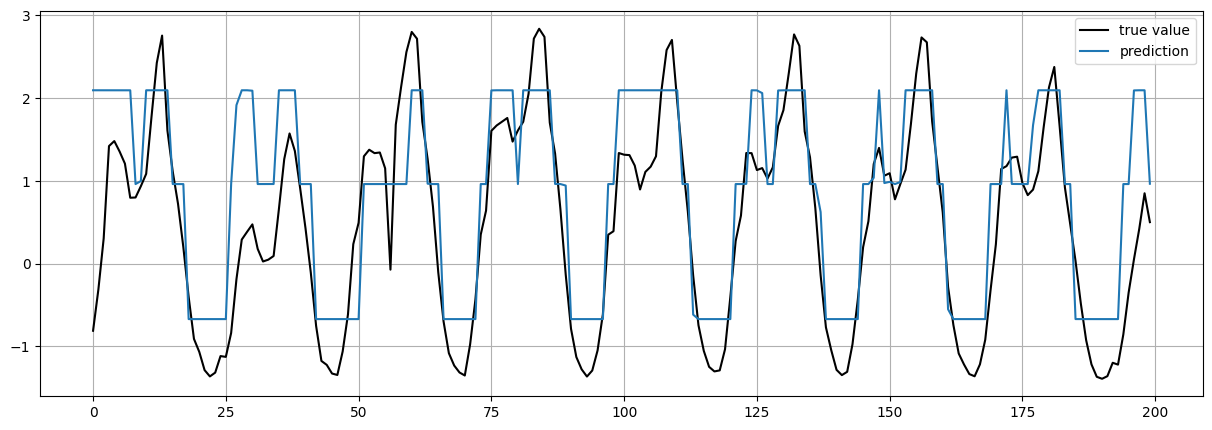

In [30]:
import matplotlib.pyplot as plt

pred = model(test_embedding)

fig = plt.figure(figsize=(15,5))
plt.plot(Yte[0:200].cpu(), label='true value', color='k')
plt.plot(pred.detach().cpu().numpy()[0:200], label='prediction')
plt.legend(loc='best', fontsize=10)
plt.grid()  
plt.show()

More testing

In [21]:
class TestModel(torch.nn.Module):
    """
    Deterministic model

    :param list widths: List of layers' widths.
    :param string activation: String specifying the activation function to use.
    """
    def __init__(self, widths):
        super().__init__()
        self.layers = torch.nn.ModuleList(
            [
                torch.nn.Linear(widths[0], widths[1]),
                torch.nn.Tanh(),
                torch.nn.Linear(widths[1], widths[2]),
            ]
        )

    def forward(self, x):
        for f in self.layers:
            x = f(x)
        return x

In [22]:
model2 = TestModel([50, 20, 1]).to(device)

In [23]:
loss = torch.nn.MSELoss()

epochs = 1000
batch_size = 1

model2.train()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.03, weight_decay=1e-2)

x = train_embedding
y = Ytr

for epoch in range(epochs):
    optimizer.zero_grad()
    for data, y in zip(train_embedding, Ytr):
        pred = model2(data)
        l = loss(pred, y)
        l.backward()
        optimizer.step()
    if epoch % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (epoch + 1, l / Ytr.shape[0]))

[iteration 0001] loss: 0.1780
[iteration 0101] loss: 0.9431
[iteration 0201] loss: 0.7153
[iteration 0301] loss: 0.5433
[iteration 0401] loss: 0.2563
[iteration 0501] loss: 1.1916
[iteration 0601] loss: 1.6941
[iteration 0701] loss: 7.3448
[iteration 0801] loss: 0.4919
[iteration 0901] loss: 3.3379


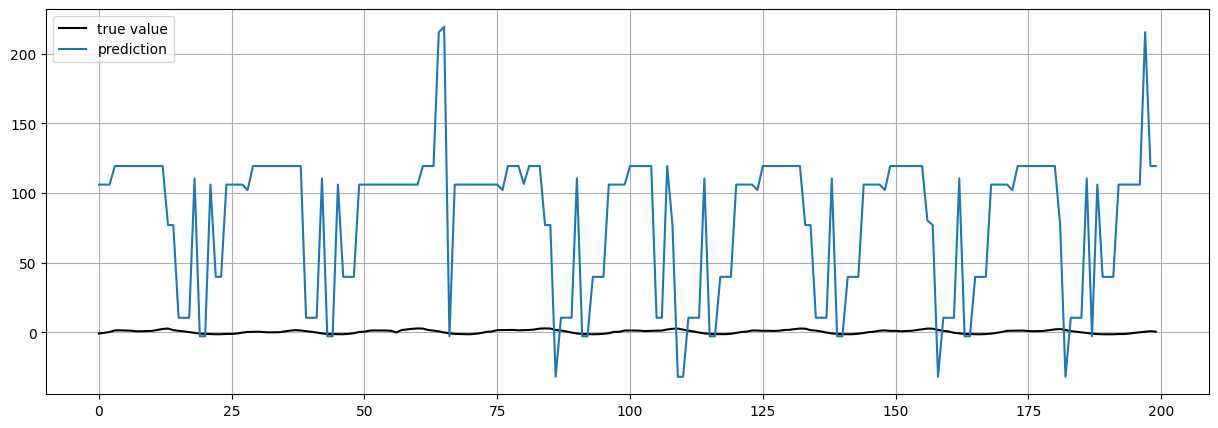

In [24]:
pred = model2(test_embedding)

fig = plt.figure(figsize=(15,5))
plt.plot(Yte[0:200].cpu(), label='true value', color='k')
plt.plot(pred.detach().cpu().numpy()[0:200], label='prediction')
plt.legend(loc='best', fontsize=10)
plt.grid()  
plt.show()

Ridge

In [26]:
from sklearn.linear_model import Ridge

x = train_embedding
y = Ytr

clf = Ridge(alpha=1.0)
clf.fit(x.cpu(), y.cpu())

Ridge()

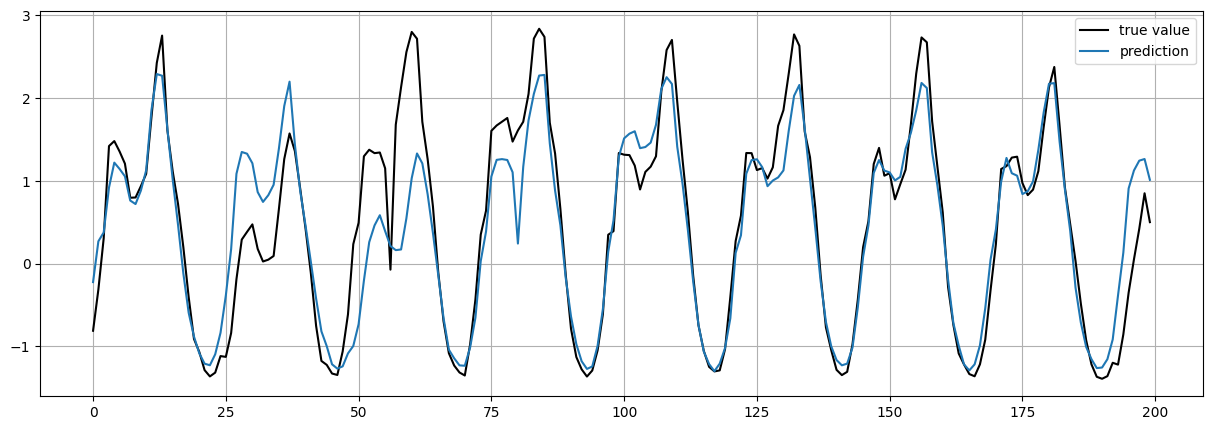

In [27]:
pred = clf.predict(test_embedding.cpu())

fig = plt.figure(figsize=(15,5))
plt.plot(Yte[0:200].cpu(), label='true value', color='k')
plt.plot(pred[0:200], label='prediction')
plt.legend(loc='best', fontsize=10)
plt.grid()  
plt.show()

Maybe use https://scikit-learn.org/stable/auto_examples/linear_model/plot_quantile_regression.html